# 10 Armed Bandit
This is a python implementation to compare the greedy and e-greddy mthods in a 10-armed bendit testbed. 
The theory is presented in Sutton, Section 2.2 - Action-value Methods

## Problem Statement
Set of 2000 randomly generated n-armed bandit problems with n=10. 

For each problem, action values $Q_* (a)$, $a = {1,…,10}$, selected according to the normal (Gaussian distribution) with mean = 0 and variance = 1. Learning method applied to problem selected action $A_t \in {1, 2, 3, ..., 10}$ , at time step t, actual reward $R_t$, was selected from a normal distribution with mean $Q_* (A_t)$ and variance = 1. learning method, we measure its performance and behaviour as it improves with experience over 100 time-steps when applied to one bandit problem, 1 run. Repeated over 2000 independent runs, each with a different bandit problem, we obtained measures of the learning algorithms behaviour.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare the 10-armed testbed experiment

To roughly assess the relative e↵ectiveness of the greedy and "-greedy action-value
methods, we compared them numerically on a suite of test problems. This was a set
of 2000 randomly generated k-armed bandit problems with k = 10. 

For each bandit
problem, such as the one shown in the figure below, the action values, $q_*(a), a = 1, . . . , 10$,

In [0]:
def generate_bandits(k=10, size=2000):
  """
  Generate one k-bandit that each value of k is normally distributed 
  around mean =  Q*(a), and variance = 1,
  while each Q*(a) is normally distributed with mean = 0 and variance = 1
  """
  
  # Generate 10 q*(a) that is normally distributed
  q_star_a = np.random.normal(0, 1, k)
  
  # Generate k bandits that has mean around q*(a) and variance 1
  bandits = [np.random.normal(k, 1, size) for k in q_star_a]
  
  return bandits

In [0]:
bandits = generate_bandits()

#### Setup the testbed

In [0]:
class Testbed(object):
  """
  Testbed generator
  
  Args:
    k: The number of arm for the bandit
  """
  
  def __init__(self, k, mean=0, stdev=1):
    
    # Number of k
    self.k = k
    
    # Use normal distribution actions
    self.mean = mean
    self.stdev = stdev
    
    self.q_star_as = np.zeros(k)
    self.optim = 0          # Store the id of highest value for greedy action
    
  def reset(self):
    # For every reset generate the bandit
    self.q_star_as = np.random.normal(self.mean, self.stdev, self.k)
    
    # Identify the maximum value in the k-armed bandits
    self.optim = np.argmax(self.q_star_as)
    

#### Preview the reward distribution of each bandit

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:588: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:816: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


[Text(0, 0.5, 'Reward distribution'), Text(0.5, 0, 'Bandits')]

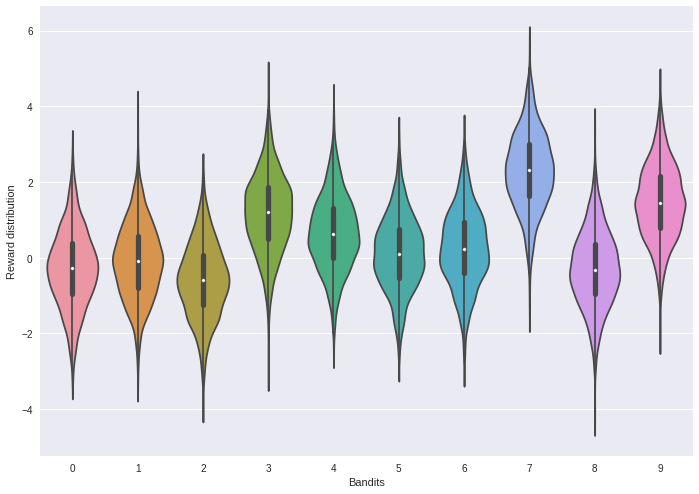

In [7]:
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = sns.violinplot(data=bandits)
ax.set(xlabel='Bandits', ylabel='Reward distribution')

## Setup the agent

In [0]:
class Agent(object):
  """
  Agent class - Controls the agent behaviour in the environment interacting
  with the testbed
  
  https://github.com/jettdlee/10_armed_bandit/blob/master/10_bandit_testbed.py
  """
  
  def __init__(self, k, eps=0):
    self.k = k
    self.eps = eps
    
    self.timestep = 0                # Timestep t
    self.last_action = None           # Store last action
    
    self.k_action = np.zeros(k)       # Count of actions taken at time t
    self.reward_sum = np.zeros(k)    # Sum of rewards
    self.q_t_a = np.zeros(k)         # Action value estimates sum(rewards)/amount
    
  def __str__(self):
    if self.eps == 0:
      return "Greedy"
    else:
      return "Episilon = " + str(self.eps)
    
  def action(self):
    """
    Action taken by agent based on a epsilon-greedy behaviour
    If epsilon == 0, then the agent performs a greedy selection
    """
    
    ### Policy ###
    
    # Epsilon method
    
    prob_e = np.random.random()      # Pick a random probability between 0 - 1
    
    if prob_e < self.eps:
      # Perform random selection
      action_t = np.random.choice(len(self.q_t_a))
    else:
      # Perform greedy method
      max_qta = np.max(self.q_t_a)          # Find max value estimate
      max_action = np.argmax(self.q_t_a)
      actions = np.where(self.q_t_a == max_qta)[0]  # Find the actions that eq max
      
      # If there is more than one action, then randomly pick one
      # otherwise, pick the maximum action
      if len(actions) > 0:
        action_t = np.random.choice(actions)
      else:
        action_t = max_action
    
    self.last_action = action_t
    
    return action_t
  
  def update_reward(self, reward):
    """
    Interpreter - Update the value estimates base on the last action
    """
    
    a_t = self.last_action
    
    self.k_action[a_t] += 1         # Add 1 to the sected action
    self.reward_sum[a_t] += reward   # Add reward to sum array
    
    # Create new action-value estimate
    self.q_t_a[a_t] = self.reward_sum[a_t] / self.k_action[a_t]
    
    # Increase the timestep
    self.timestep += 1
    
  def reset(self):
    self.timestep = 0
    self.last_action = None
    self.k_action[:] = 0
    self.reward_sum[:] = 0
    self.q_t_a[:] = 0

In [0]:
class Environment(object):
  """
  Environment class to control all objects (agent/testbed)
  
  Args:
    testbed: The testbed of k-armed bandit
    agents: The agents, with specific configuration on eps
    plays (int): Number of plays to play
    iterations (int): Number of iterations to generate Q*(a)
  """
  
  def __init__(self, testbed, agents, plays, iterations=1000):
    self.testbed = testbed
    self.agents = agents
    self.plays = plays
    self.iterations = iterations
    
  def play(self):
    """
    Run test - Play the game
    """
    
    agent_count = 0
    
    # score matrix, number of plays x number of agents
    scores = np.zeros((self.plays, len(self.agents)))
    
    # Array to maintain optimal count - Graph 2
    optimal_counts = np.zeros((self.plays, len(self.agents)))
    
    # loop for number of iterations
    for i in range(self.iterations):
      
      if (i % 100) == 0:
        print("Completed Iterations: " + str(i))
        
      # Reset testbed and all agents
      self.testbed.reset()
      for agent in self.agents:
        agent.reset()
        
      # Loop for number of plays
      for p in range(self.plays):
        
        agent_count = 0
      
        for agent in self.agents:
          action_t = agent.action()
          
          # Reward is in normal distribution with mean Q*(at), var = 1
          reward_t = np.random.normal(self.testbed.q_star_as[action_t], scale=1)
          
          # Update agent state
          agent.update_reward(reward=reward_t)
          
          # Add the score in array
          scores[p, agent_count] += reward_t
          
          # Check the optimal action, add optimal to array
          if action_t == self.testbed.optim:
            optimal_counts[p, agent_count] += 1
            
          agent_count += 1
          
    
    # Return averages
    score_average = scores / self.iterations
    optimal_average = optimal_counts / self.iterations
    
    return score_average, optimal_average
      

#### Start running the experiment

In [0]:
k = 10
iterations = 2000
plays = 1000

In [0]:
testbed = Testbed(k)
agents = [Agent(k=k), Agent(k=k, eps=0.01), Agent(k=k, eps=0.1)]
environment = Environment(testbed=testbed, agents=agents,
                          plays=plays, iterations=iterations)

In [78]:
g1Scores, g2Optimal = environment.play()

Completed Iterations: 0
Completed Iterations: 100
Completed Iterations: 200
Completed Iterations: 300
Completed Iterations: 400
Completed Iterations: 500
Completed Iterations: 600
Completed Iterations: 700
Completed Iterations: 800
Completed Iterations: 900
Completed Iterations: 1000
Completed Iterations: 1100
Completed Iterations: 1200
Completed Iterations: 1300
Completed Iterations: 1400
Completed Iterations: 1500
Completed Iterations: 1600
Completed Iterations: 1700
Completed Iterations: 1800
Completed Iterations: 1900


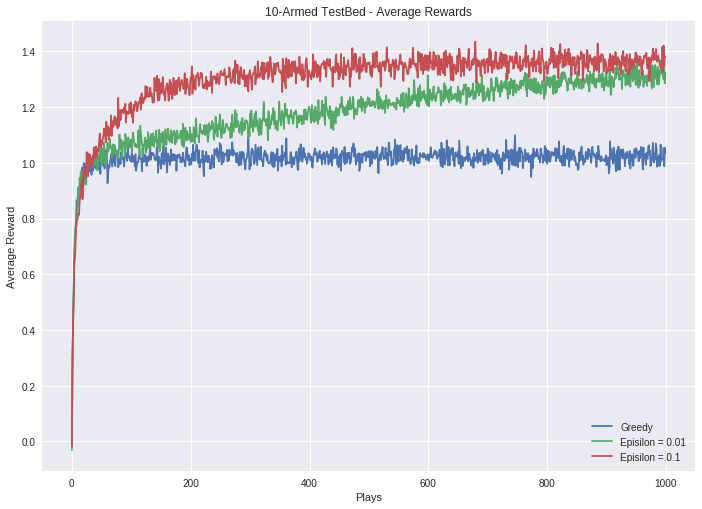

In [79]:
# Average reward chart
  plt.title("10-Armed TestBed - Average Rewards")
  plt.plot(g1Scores)
  plt.ylabel('Average Reward')
  plt.xlabel('Plays')
  plt.legend(agents, loc=4)
  plt.show()

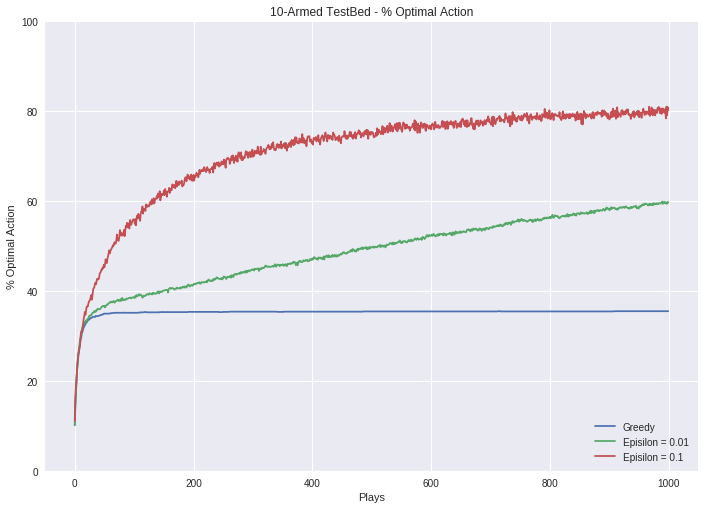

In [80]:
# Graph 2
plt.title("10-Armed TestBed - % Optimal Action")
plt.plot(g2Optimal * 100)
plt.ylim(0, 100)
plt.ylabel('% Optimal Action')
plt.xlabel('Plays')
plt.legend(agents, loc=4)
plt.show()